## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.


In [4]:
### Environment setup
import sys
sys.path.append('/content')
from src.fluvius import WaterData, WaterStation
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd
import fsspec
from pystac_client import Client
import planetary_computer as pc
import os

import matplotlib.pyplot as plt
# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value

#################  set up ####################
data_source = 'itv'
container = f'{data_source}-data'
############## initial parameters ##############
if data_source == 'usgs':
    day_tolerance = 0 #reduce this for usgs-data
else:
    day_tolerance = 8 
cloud_thr = 80
buffer_distance = 500 # change this to increase chip size in meter 
################################################

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY'],
                 'connection_string': os.environ['CONNECTION_STRING']}

fs = fsspec.filesystem('az',\
                       account_name=storage_options['account_name'],\
                       account_key=storage_options['account_key'])   


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ds = WaterData(data_source, container, storage_options)
ds.get_source_df()
ds.apply_buffer_to_points(buffer_distance)
ds.generate_map()
ds.plot_map

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
ds.get_station_data('ITV3')

In [17]:
ds.station

{'ITV1': <src.fluvius.WaterStation at 0x7fc8bc0ff940>,
 'ITV2': <src.fluvius.WaterStation at 0x7fc8bc138b50>,
 'ITV3': <src.fluvius.WaterStation at 0x7fc873f19910>}

In [18]:
ds.station['ITV3'].df

,sample_id,Campaign,Campaign Date,Drainage Area (km²),SSC (mg/l),Q (m³/s),Date-Time
0,0000ITV3_00000001,1.0,01/06/2015,2644.52,24.85,25.60,2015-06-01
1,0000ITV3_00000002,2.0,20/09/2015,2644.52,20.60,1.98,2015-09-20
2,0000ITV3_00000003,3.0,21/02/2016,2644.52,19.48,17.91,2016-02-21
3,0000ITV3_00000004,4.0,16/04/2016,2644.52,19.48,93.33,2016-04-16
4,0000ITV3_00000005,5.0,25/06/2016,2644.52,22.64,6.79,2016-06-25
5,0000ITV3_00000006,6.0,17/09/2016,2644.52,26.47,1.09,2016-09-17
6,0000ITV3_00000007,7.0,04/02/2017,2644.52,45.44,92.21,2017-02-04
7,0000ITV3_00000008,8.0,08/04/2017,2644.52,13.83,172.64,2017-04-08
8,0000ITV3_00000009,9.0,24/06/2017,2644.52,19.66,18.98,2017-06-24
9,0000ITV3_00000010,10.0,11/09/2017,2644.52,21.69,2.22,2017-09-11


In [38]:
#full loop
for station in ds.df['site_no']:
    ds.get_station_data(station)
    ds.station[station].build_catalog()
    if ds.station[station].catalog is None:
        print('No matching images! Skipping...')
        continue
    else:
        ds.station[station].get_cloud_filtered_image_df(cloud_thr)
        ds.station[station].merge_image_df_with_samples(day_tolerance)
        ds.station[station].perform_chip_cloud_analysis()
        ds.station[station].get_reflectances()
        sstation = str(station).zfill(8)
        '''
        outfilename = f'az://{ds.container}/stations/{sstation}/{sstation}_processed.csv'
        ds.station[station].merged_df.to_csv(outfilename,index=False,storage_options=ds.storage_options)
        print(f'wrote csv {outfilename}')
        print('writing chips!')
        ds.station[station].write_tiles_to_blob(working_dirc='/tmp')
        '''

building catalog for station ITV1 with sentinel-2-l2a!
471 Items found
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/EE/2018/10/01/S2B_MSIL2A_20181001T135109_N0212_R024_T22MEE_20201009T070506.SAFE/GRANULE/L2A_T22MEE_A008201_20181001T135107/IMG_DATA/R20m/T22MEE_20181001T135109_SCL_20m.tif cloud chip error!
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/EE/2019/01/24/S2A_MSIL2A_20190124T135111_N0212_R024_T22MEE_20201008T041303.SAFE/GRANULE/L2A_T22MEE_A018754_20190124T135109/IMG_DATA/R20m/T22MEE_20190124T135111_SCL_20m.tif cloud chip error!
building catalog for station ITV2 with sentinel-2-l2a!
316 Items found
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/DE/2017/04/04/S2A_MSIL2A_20170404T135111_N0212_R024_T22MDE_20210209T044255.SAFE/GRANULE/L2A_T22MDE_A009316_20170404T135109/IMG_DATA/R20m/T22MDE_20170404T135111_SCL_20m.tif cloud chip error!
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/DE/2018/10/01/S2B_MSIL2A_20181001T13

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/FE/2019/09/13/S2B_MSIL2A_20190913T134209_N0212_R124_T22MFE_20201004T124933.SAFE/GRANULE/L2A_T22MFE_A013163_20190913T134211/IMG_DATA/R20m/T22MFE_20190913T134209_SCL_20m.tif cloud chip error!
building catalog for station ITV10 with sentinel-2-l2a!
321 Items found
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/EE/2017/04/04/S2A_MSIL2A_20170404T135111_N0212_R024_T22MEE_20210209T044300.SAFE/GRANULE/L2A_T22MEE_A009316_20170404T135109/IMG_DATA/R20m/T22MEE_20170404T135111_SCL_20m.tif cloud chip error!
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/EE/2018/04/19/S2A_MSIL2A_20180419T135111_N0212_R024_T22MEE_20201013T000005.SAFE/GRANULE/L2A_T22MEE_A014750_20180419T135113/IMG_DATA/R20m/T22MEE_20180419T135111_SCL_20m.tif cloud chip error!
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/EE/2018/10/01/S2B_MSIL2A_20181001T135109_N0212_R024_T22MEE_20201009T070506.SAFE/GRANULE/L2A_T22MEE_A008201

In [20]:
station = 'ITV4' 
ds.get_station_data(station)

In [21]:
ds.station[station].build_catalog()

building catalog for station ITV4 with sentinel-2-l2a!
483 Items found


In [22]:
c = ds.station[station].catalog

In [24]:
c.items()

<generator object ItemSearch.items at 0x7fc87274a660>

In [25]:
out = [i for i in c.items()]

In [29]:
a = next(c.items())

In [36]:
a.

{'platform': 'Sentinel-2B',
 'constellation': 'Sentinel 2',
 'instruments': ['msi'],
 'eo:cloud_cover': 25.959327,
 'sat:orbit_state': 'descending',
 'sat:relative_orbit': 24,
 'proj:epsg': 32722,
 's2:product_uri': 'S2B_MSIL2A_20190827T135119_N0212_R024_T22MEE_20201106T053643.SAFE',
 's2:generation_time': '2020-11-06T05:36:43.676Z',
 's2:processing_baseline': '02.12',
 's2:product_type': 'S2MSI2A',
 's2:datatake_id': 'GS2B_20190827T135119_012920_N02.12',
 's2:datatake_type': 'INS-NOBS',
 's2:datastrip_id': 'S2B_OPER_MSI_L2A_DS_ESRI_20201106T053644_S20190827T135116_N02.12',
 's2:granule_id': 'S2B_OPER_MSI_L2A_TL_ESRI_20201106T053644_A012920_T22MEE_N02.12',
 's2:mgrs_tile': '22MEE',
 's2:reflectance_conversion_factor': 0.978363904576633,
 's2:degraded_msi_data_percentage': 0.0,
 's2:nodata_pixel_percentage': 0.0,
 's2:saturated_defective_pixel_percentage': 0.0,
 's2:dark_features_percentage': 0.301346,
 's2:cloud_shadow_percentage': 2.410168,
 's2:vegetation_percentage': 49.653685,
 's2

In [37]:
sample_id = ds.station[station].merged_df.sample_id.iloc[1]
ds.station[station].visualize_chip(sample_id)

AttributeError: 'WaterStation' object has no attribute 'merged_df'

In [109]:
np.mean(np.array(img)[water_mask],axis=0)

array([58.03409091, 57.53787879, 36.66287879])

In [26]:
station = ds.df.iloc[4].site_no
ds.get_station_data(station)
ds.station[station].build_catalog()
ds.station[station].get_cloud_filtered_image_df(cloud_thr)
ds.station[station].merge_image_df_with_samples(day_tolerance)
ds.station[station].perform_chip_cloud_analysis()
ds.station[station].get_reflectances()

building catalog for station 01646305 with sentinel-2-l2a!
162 Items found


<AxesSubplot:>

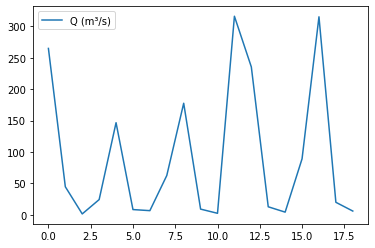

In [12]:
import matplotlib.pyplot as plt
ds.station[station].df[['Date-Time','Q (m³/s)']].plot()

In [46]:
g = fs.ls('itv-data/stations')
#a = [f for f in g if any(map(str.isdigit, f))]
a = [f for f in g if 'csv' in f]
#out = [f"{o.split('/')[0]}/raw/{o.split('/')[-1]}" for o in a]
out = [f"{o.split('/')[0]}/stations/{str(o.split('/')[-1][:-4]).zfill(8)}.csv" for o in a]

for i,o in zip(a,out):
    #print(i,o)
    fs.mv(i,o)

In [44]:
out

['itv-data/0000ITV1.csv',
 'itv-data/000ITV10.csv',
 'itv-data/000ITV11.csv',
 'itv-data/000ITV12.csv',
 'itv-data/000ITV13.csv',
 'itv-data/000ITV14.csv',
 'itv-data/000ITV15.csv',
 'itv-data/000ITV16.csv',
 'itv-data/0000ITV2.csv',
 'itv-data/0000ITV3.csv',
 'itv-data/0000ITV4.csv',
 'itv-data/0000ITV5.csv',
 'itv-data/0000ITV6.csv',
 'itv-data/0000ITV7.csv',
 'itv-data/0000ITV8.csv',
 'itv-data/0000ITV9.csv']